# Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import altair as alt
from altair_saver import save
import datetime

In [2]:
alt.renderers.enable('mimetype')
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

### Load Data

Set train data to 2017 and earlier.

In [3]:
ORD = pd.read_csv('../data/ORD.csv', index_col='Unnamed: 0')
ORD_train = ORD[ORD['year'] < 2018]

In [4]:
ORD_train.head(5)

,year,month,day,hour,rides,tmpf,dwpf,relh,sknt,p01i,vsby,feel,skyc,seats,airline
0,2013,1,1,0,22,24.98,17.96,74.290000,9.000000,0.0,9.000000,14.780000,3.000000,547.520724,3.0
1,2013,1,1,1,9,24.89,17.78,73.995000,9.000000,0.0,8.000000,14.670000,5.000000,147.962430,1.0
2,2013,1,1,2,11,21.20,14.00,73.320000,10.000000,0.0,9.000000,9.420000,5.000000,NaN,NaN
3,2013,1,1,3,3,21.14,12.14,67.723333,10.666667,0.0,9.666667,8.976667,4.333333,NaN,NaN
4,2013,1,1,4,5,19.94,10.94,67.580000,10.000000,0.0,10.000000,7.840000,5.000000,847.150186,4.0


### Add Datetime Features

In [5]:
ORD_train = ORD_train.assign(datetime=ORD_train.apply(lambda x: datetime.datetime(int(x['year']),int(x['month']),int(x['day'])), axis=1))
ORD_train = ORD_train.assign(dayofweek=pd.DatetimeIndex(ORD_train['datetime']).dayofweek)

In [6]:
ORD_train.head(5)

,year,month,day,hour,rides,tmpf,dwpf,relh,sknt,p01i,vsby,feel,skyc,seats,airline,datetime,dayofweek
0,2013,1,1,0,22,24.98,17.96,74.290000,9.000000,0.0,9.000000,14.780000,3.000000,547.520724,3.0,2013-01-01,1
1,2013,1,1,1,9,24.89,17.78,73.995000,9.000000,0.0,8.000000,14.670000,5.000000,147.962430,1.0,2013-01-01,1
2,2013,1,1,2,11,21.20,14.00,73.320000,10.000000,0.0,9.000000,9.420000,5.000000,NaN,NaN,2013-01-01,1
3,2013,1,1,3,3,21.14,12.14,67.723333,10.666667,0.0,9.666667,8.976667,4.333333,NaN,NaN,2013-01-01,1
4,2013,1,1,4,5,19.94,10.94,67.580000,10.000000,0.0,10.000000,7.840000,5.000000,847.150186,4.0,2013-01-01,1


**Note:** Day of Week = 0 is Monday

### Add Lagged Features

In [7]:
def lag_df(df, lag, cols):
    return df.assign(**{f"{col}-{n}": df[col].shift(n) for n in range(1, lag + 1) for col in cols})

In [8]:
lag = 3
ORD_train_lag = lag_df(ORD_train, lag=lag, cols=['seats'])

In [9]:
ORD_train_lag.head(5)

,year,month,day,hour,rides,tmpf,dwpf,relh,sknt,p01i,vsby,feel,skyc,seats,airline,datetime,dayofweek,seats-1,seats-2,seats-3
0,2013,1,1,0,22,24.98,17.96,74.290000,9.000000,0.0,9.000000,14.780000,3.000000,547.520724,3.0,2013-01-01,1,NaN,NaN,NaN
1,2013,1,1,1,9,24.89,17.78,73.995000,9.000000,0.0,8.000000,14.670000,5.000000,147.962430,1.0,2013-01-01,1,547.520724,NaN,NaN
2,2013,1,1,2,11,21.20,14.00,73.320000,10.000000,0.0,9.000000,9.420000,5.000000,NaN,NaN,2013-01-01,1,147.962430,547.520724,NaN
3,2013,1,1,3,3,21.14,12.14,67.723333,10.666667,0.0,9.666667,8.976667,4.333333,NaN,NaN,2013-01-01,1,NaN,147.962430,547.520724
4,2013,1,1,4,5,19.94,10.94,67.580000,10.000000,0.0,10.000000,7.840000,5.000000,847.150186,4.0,2013-01-01,1,NaN,NaN,147.962430


### What are the correlations between variables?

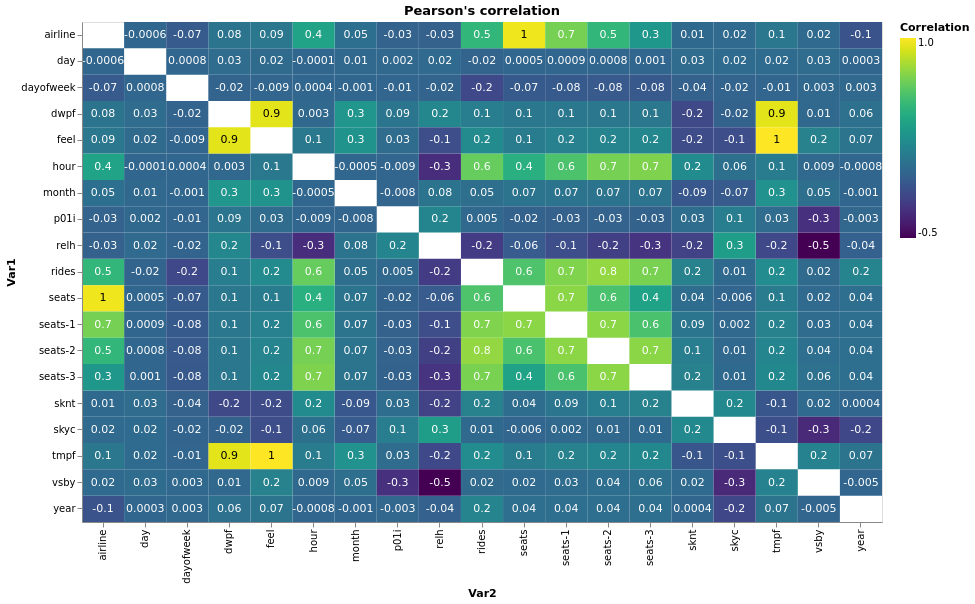

In [10]:
ORD_corr = ORD_train_lag.corr().reset_index().rename(columns = {'index':'Var1'}).melt(id_vars = ['Var1'],
                                                                                    value_name = 'Correlation',
                                                                                    var_name = 'Var2')
ORD_corr = ORD_corr[ORD_corr.Correlation != 1]

base = alt.Chart(ORD_corr).encode(
    alt.Y('Var1:N'),
    alt.X('Var2:N')
) 

heatmap = base.mark_rect().encode(
     alt.Color('Correlation:Q',
                scale=alt.Scale(scheme='viridis'))
)

text = base.mark_text(baseline='middle').encode(
    text=alt.Text('Correlation:Q', format='.1'),
    color=alt.condition(
        alt.datum.Correlation >= 0.90,
        alt.value('black'),
        alt.value('white')
    )
)

(heatmap + text).properties(
    width = 800,
    height = 500,
    title = "Pearson's correlation"
)

#### Observations:
- `rides` is strongly correlated to `airline` (number of planes in an hour), `hour` (more traffic later in the day), and `seats` (number of seats in an hour).
- Of the lagged `seats` data, `seats-2` (number of seats two hours ago) has the highest correlation to current taxi rides. This suggests that it takes time for people to get through the airport and collect their baggage after landing before requiring taxi service.
- Weather variables seem uncorrelated to the number of rides with a max correlation of only **0.2**. This could be that individuals travelling by airplane ususally have a fixed plan of travel upon arrival to the airport and are not heavily swayed by weather conditions.
- Weather variables are correlated to each other as expected: `skyc` and `relh` (sky condition and relative humidtiy), `feel` and `tmpf` (feels like temp. and temperature), `vsby` and `skyc`, `p01i`, `relh` (visibility and sky condition, precipitation, relative humidty)
- `airline` is perfectly correlated to `seats`, which makes sense, since the number of seats is dependent on the number of planes in an hour. This suggests `airline` is likely a redundant feature.

### How does number of seats change across time?

In [11]:
p1 = alt.Chart(ORD_train).mark_trail().encode(
    x = alt.X('hour:N', title = "Hour"),
    y = alt.Y('mean(seats):Q', title = "Average Seat Count"),
    color = alt.Color('year:N', title = "Year")
).properties(
    height = 300,
    width = 400,
    title = "Seats vs Hour"
)

p2 = alt.Chart(ORD_train).mark_trail().encode(
    x = alt.X('dayofweek:N', title = "Day of Week"),
    y = alt.Y('mean(seats):Q', title = "Average Seat Count"),
    color = alt.Color('year:N', title = "Year")
).properties(
    height = 300,
    width = 400,
    title = "Seats vs Day of Week"
)

p3 = alt.Chart(ORD_train).mark_trail().encode(
    x = alt.X('day:N', title = "Day"),
    y = alt.Y('mean(seats):Q', title = "Average Seat Count"),
    color = alt.Color('year:N', title = "Year")
).properties(
    height = 300,
    width = 400,
    title = "Seats vs Day"
)

p4 = alt.Chart(ORD_train).mark_trail().encode(
    x = alt.X('month:N', title = "Month"),
    y = alt.Y('mean(seats):Q', title = "Average Seat Count"),
    color = alt.Color('year:N', title = "Year")
).properties(
    height = 300,
    width = 400,
    title = "Seats vs Month"
)

p5 = alt.Chart(ORD_train).mark_trail().encode(
    x = alt.X('year:N', title = "Year"),
    y = alt.Y('mean(seats):Q', title = "Average Seat Count")
).properties(
    height = 300,
    width = 400,
    title = "Seats vs Year"
)

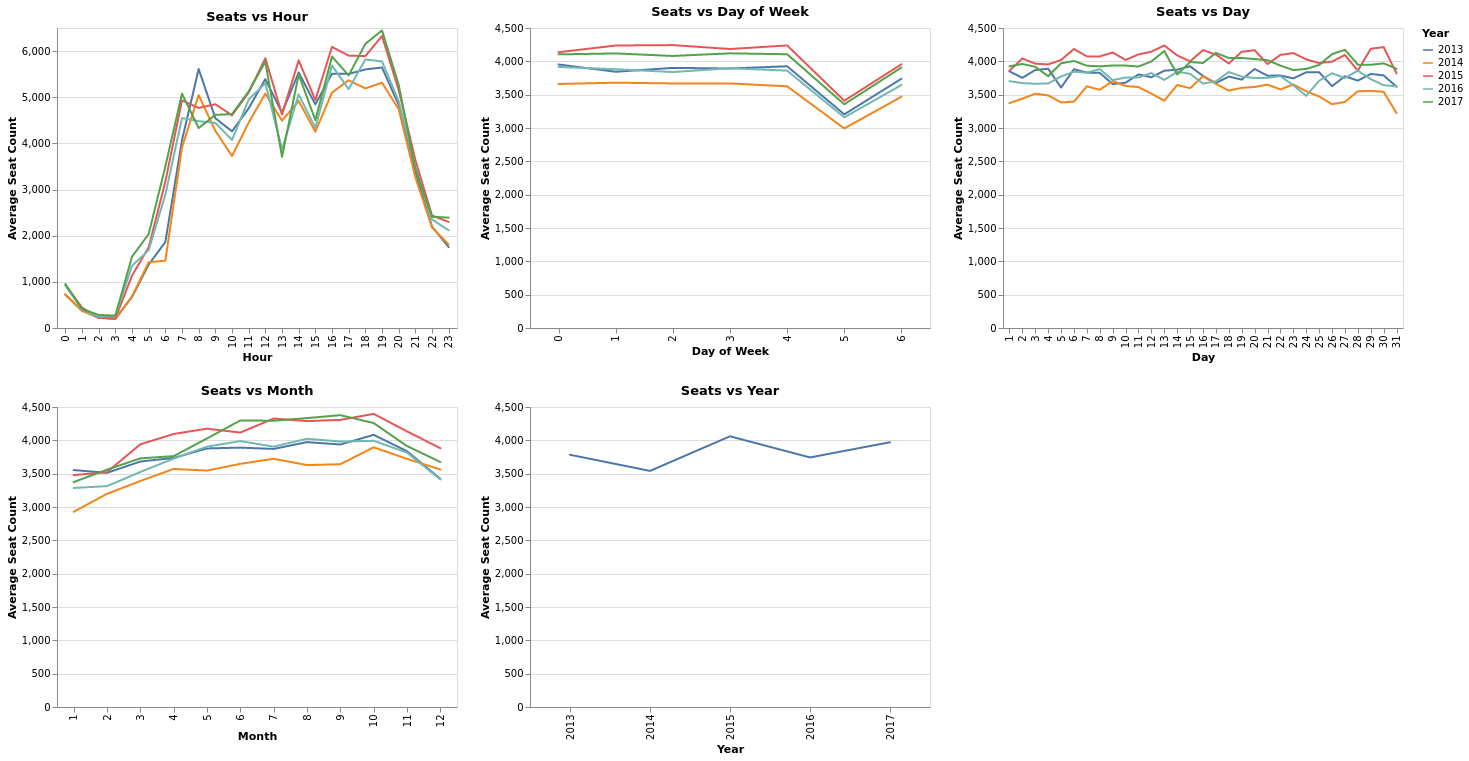

In [12]:
alt.vconcat(p1 | p2 | p3, p4 | p5)

#### Observations:
- Peak times: 6am to 10pm
- Flights steady throughout week with exception of Friday.
- Flights slightly more common in the Summer

### How does number of rides change across time?

In [15]:
p6 = alt.Chart(ORD_train).mark_trail().encode(
    x = alt.X('hour:N', title = "Hour"),
    y = alt.Y('mean(rides):Q', title = "Average Rides"),
    color = alt.Color('year:N', title = "Year")
).properties(
    height = 300,
    width = 400,
    title = "Rides vs Hour"
)

p7 = alt.Chart(ORD_train).mark_trail().encode(
    x = alt.X('dayofweek:N', title = "Day of Week"),
    y = alt.Y('mean(rides):Q', title = "Average Rides"),
    color = alt.Color('year:N', title = "Year")
).properties(
    height = 300,
    width = 400,
    title = "Rides vs Day of Week"
)

p8 = alt.Chart(ORD_train).mark_trail().encode(
    x = alt.X('day:N', title = "Day"),
    y = alt.Y('mean(rides):Q', title = "Average Rides"),
    color = alt.Color('year:N', title = "Year")
).properties(
    height = 300,
    width = 400,
    title = "Rides vs Day"
)

p9 = alt.Chart(ORD_train).mark_trail().encode(
    x = alt.X('month:N', title = "Month"),
    y = alt.Y('mean(rides):Q', title = "Average Rides"),
    color = alt.Color('year:N', title = "Year")
).properties(
    height = 300,
    width = 400,
    title = "Rides vs Month"
)

p10 = alt.Chart(ORD_train).mark_trail().encode(
    x = alt.X('year:N', title = "Year"),
    y = alt.Y('mean(rides):Q', title = "Average Rides"),
).properties(
    height = 300,
    width = 400,
    title = "Rides vs Year"
)

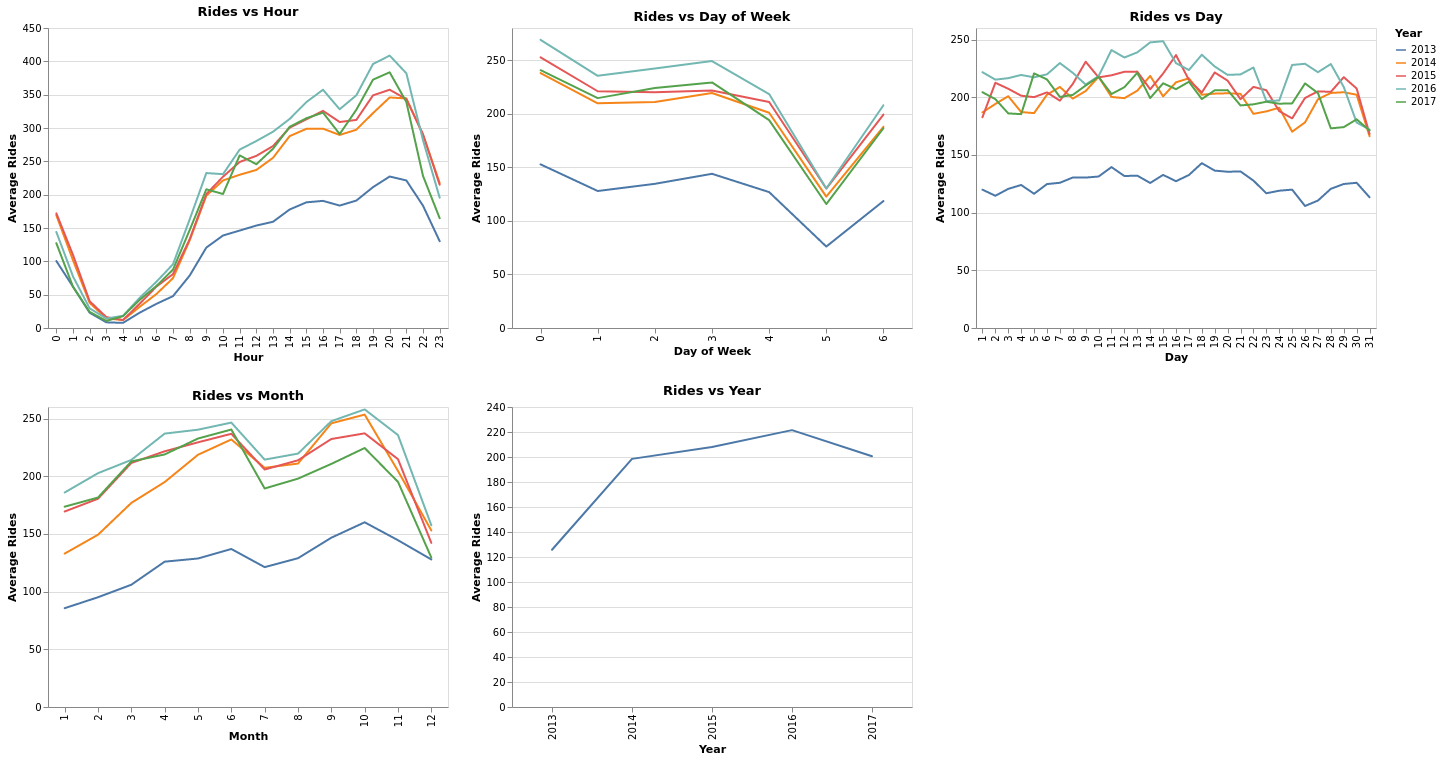

In [16]:
alt.vconcat(p6 | p7 | p8, p9 | p10)

#### Observations:
- `rides` appears to lag behind `seats` about 2 hours: peak times 8am to 9pm.
- `rides` drops much more signficantly than flights on Friday (24% vs 12%). Could be because increased demand elsewhere in the city (Friday night partiers).
- most popular day for `rides` is Monday. Perhaps many fresh taxi drivers starting up for the week.
- `rides` in Summer high; however there is a drop in July and August. Perhaps due to taxi drivers taking Vacation.
- `rides` significantly less in 2013. Potential reasons why: drivers on strike, lack of data collection.

#### Further Visualization For Flights and Rides Frequencies:

In [70]:
p_11 = alt.Chart(ORD_train).mark_rect().encode(
    alt.X('hour:O', title='hour of day'),
    alt.Y('dayofweek:O', title='date'),
    alt.Color('seats:Q', title='rides per hour')
).facet(
    facet='year:N',
    columns=3
).properties(
title = 'Seats vs Day of Week and Hour'
)

p_12 = alt.Chart(ORD_train).mark_rect().encode(
    alt.X('hour:O', title='hour of day'),
    alt.Y('dayofweek:O', title='date'),
    alt.Color('rides:Q', title='rides per hour')
).facet(
    facet='year:N',
    columns=3
).properties(
title = 'Rides vs Day of Week and Hour'
)

p_13 = alt.Chart(ORD_train.groupby(['year','month','day']).sum().reset_index()).mark_rect().encode(
    alt.X('day:N', title='day of month'),
    alt.Y('month:O', title='month'),
    alt.Color('seats:Q', title='seats per hour')
).facet(
    facet='year:N',
    columns=3
).properties(
title = 'Seats vs Month and Day of Month'
)

p_14 = alt.Chart(ORD_train.groupby(['year','month','day']).sum().reset_index()).mark_rect().encode(
    alt.X('day:N', title='day of month'),
    alt.Y('month:O', title='month'),
    alt.Color('rides:Q', title='rides per day of week')
).facet(
    facet='year:N',
    columns=3
).properties(
title = 'Rides vs Month and Day of Month'
)

p_15 = alt.Chart(ORD_train.groupby(['year','month','dayofweek']).sum().reset_index()).mark_rect().encode(
    alt.X('dayofweek:N', title='day of week'),
    alt.Y('month:O', title='month'),
    alt.Color('seats:Q', title='seats per hour')
).facet(
    facet='year:N',
    columns=3
).properties(
title = 'Seats vs Month and Day of Week'
)

p_16 = alt.Chart(ORD_train.groupby(['year','month','dayofweek']).sum().reset_index()).mark_rect().encode(
    alt.X('dayofweek:N', title='day of week'),
    alt.Y('month:O', title='month'),
    alt.Color('rides:Q', title='rides per day of week')
).facet(
    facet='year:N',
    columns=3
).properties(
title = 'Rides vs Month and Day of Week'
)

In [75]:
plot_list = [p_11, p_12, p_13, p_14, p_15, p_16]

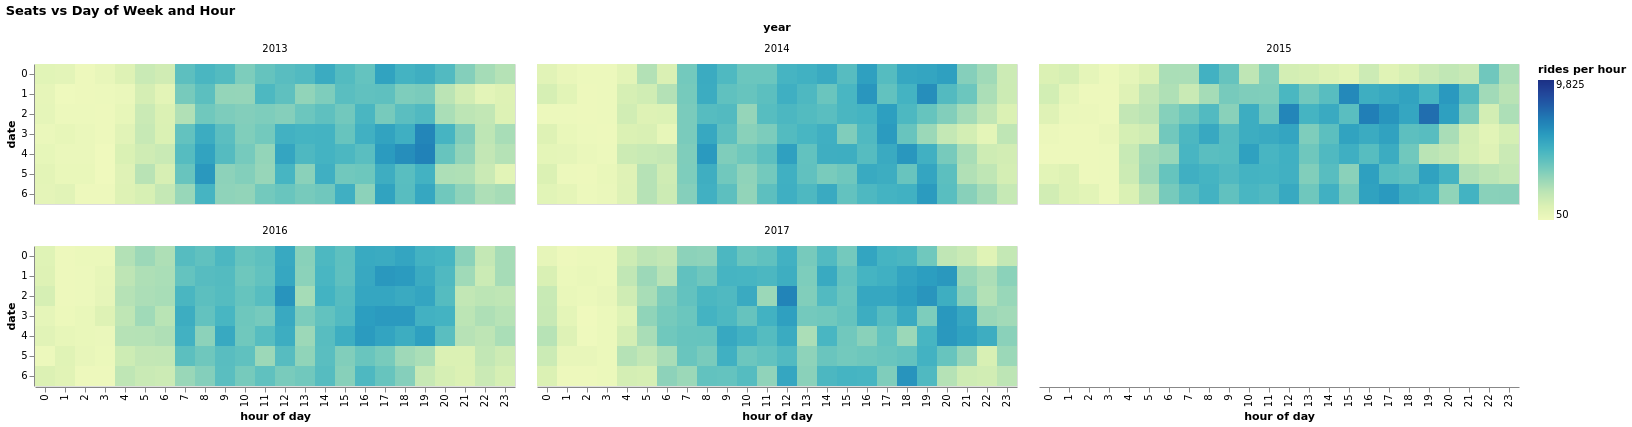

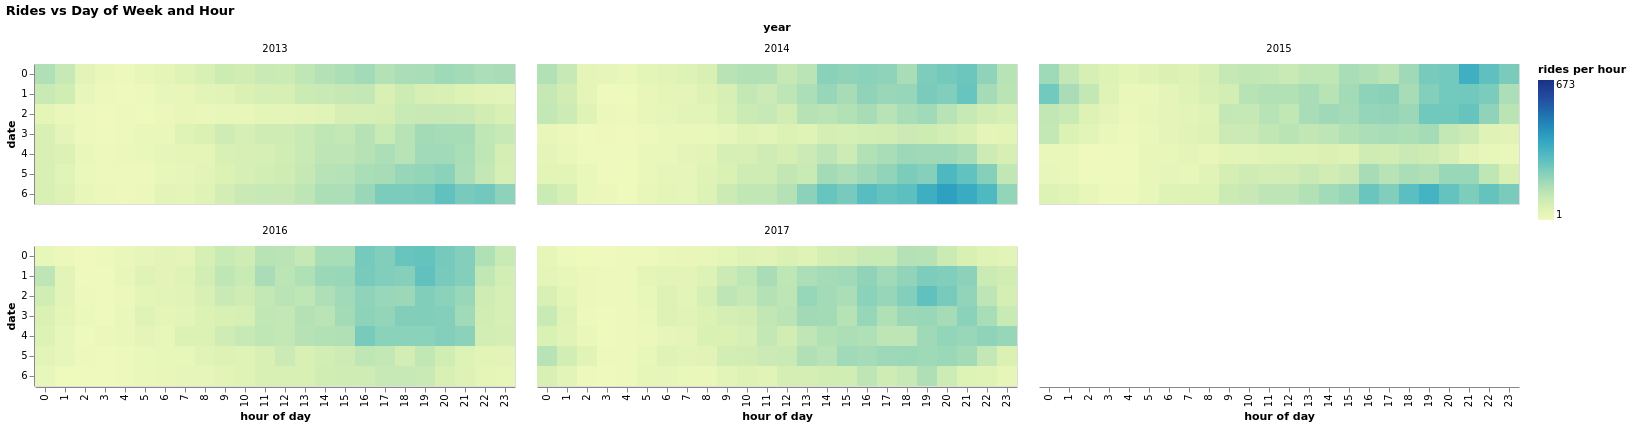

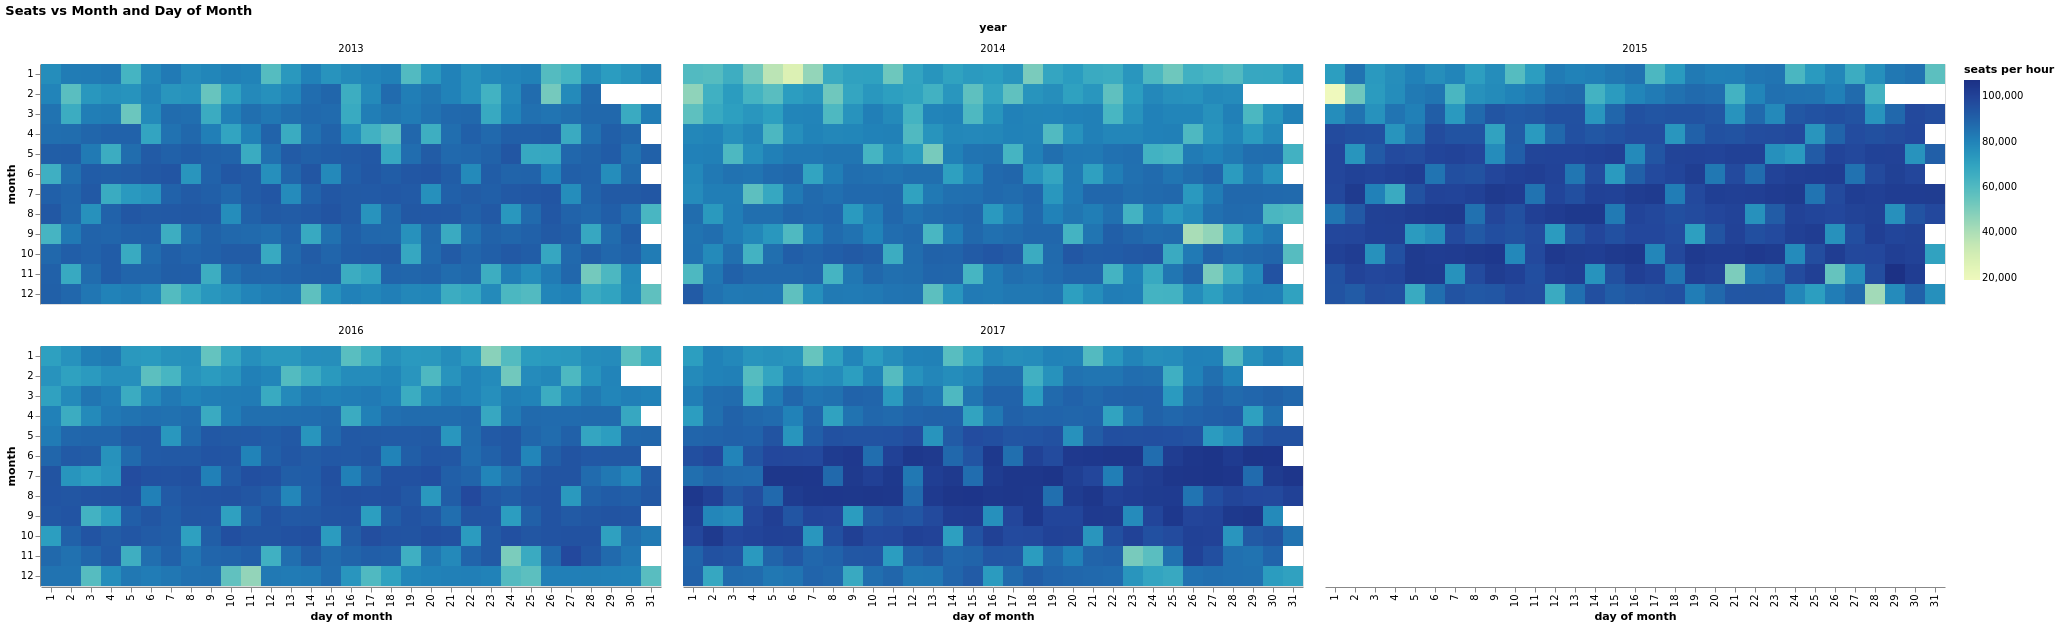

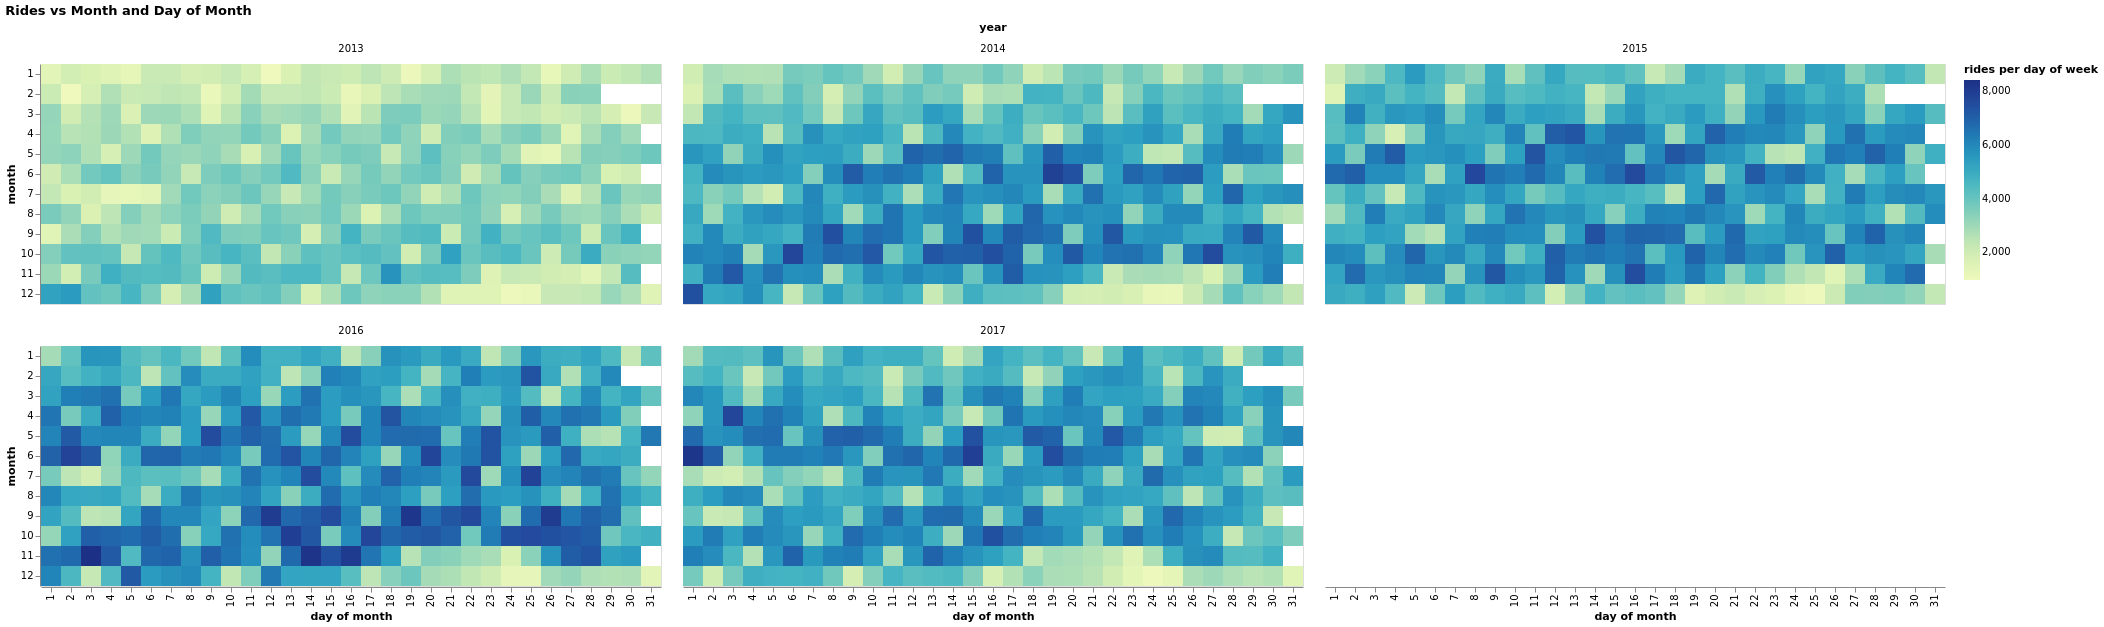

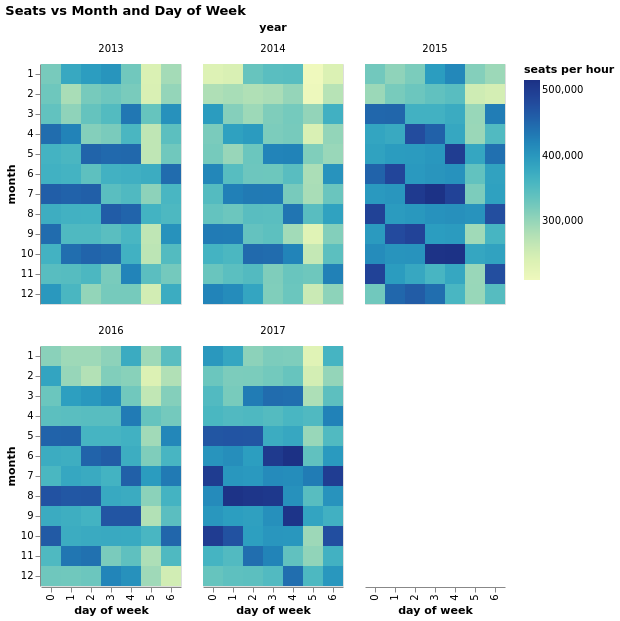

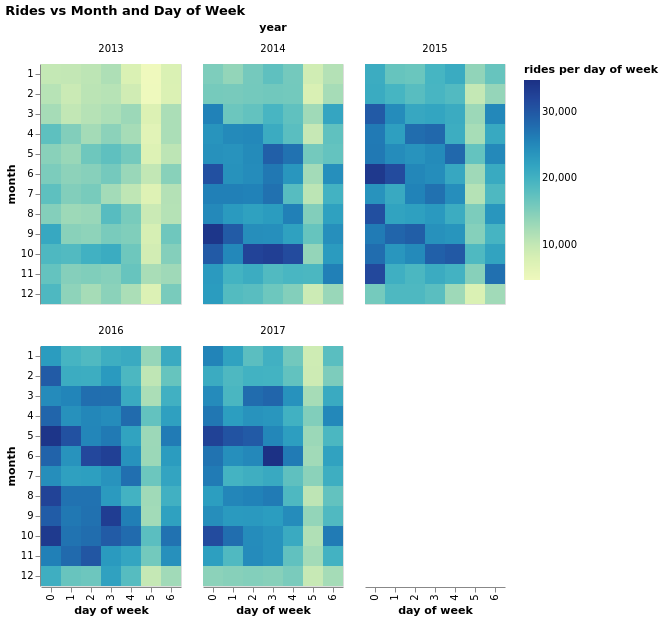

In [76]:
for p in plot_list:
    display(p)

Observations:
- `seats` and `rides` across `dayofweek` appear like steps because of moving holidays.
- some days like Chirstmas a have constant lower `seats` and `rides`

### How does number of rides change with Weather?

Most correlated weather variables:

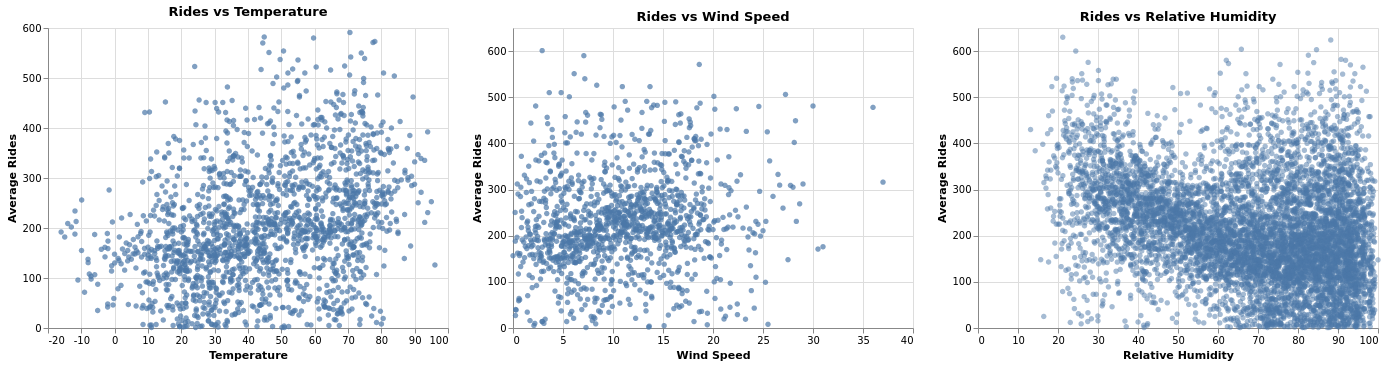

In [30]:
p_10 = alt.Chart(ORD_train).mark_circle(opacity=0.7).encode(
    x = alt.X('tmpf:Q', title = "Temperature"),
    y = alt.Y('mean(rides):Q', title = "Average Rides")
).properties(
    title = "Rides vs Temperature"
)

p_11 = alt.Chart(ORD_train).mark_circle(opacity=0.7).encode(
    x = alt.X('sknt:Q', title = "Wind Speed"),
    y = alt.Y('mean(rides):Q', title = "Average Rides")
).properties(
    title = "Rides vs Wind Speed"
)

p_12 = alt.Chart(ORD_train).mark_circle(opacity=0.5).encode(
    x = alt.X('relh:Q', title = "Relative Humidity"),
    y = alt.Y('mean(rides):Q', title = "Average Rides")
).properties(
    title = "Rides vs Relative Humidity"
)

p_10 | p_11 | p_12

#### Observations:
- More rides slightly tend to occur when it's hot outside.
- More rides slightly tend to occur when it's windy.
- Many rides rapidly occur once humidity drops below 60%.